##### Model user’s skipping behavior: Build and estimate (or train) a model on the first 15,000 observations in the data (thetraining and validation sample) that provides the most accurate and robust predictionsof user skipping behavior on the last 5,000 observationsin the data (the hold-out sample).

#### Meaning of every song feature in the spotify

In [90]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as spst
from scipy.optimize import minimize
import scipy.special as spsp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [162]:
data=pd.read_csv('spotify.csv')
data['early']=data['early'].apply(lambda x: int(x))
data['late']=data['late'].apply(lambda x: int(x))
data
df=data.copy()
df['skip_speed']=[df['early'][i]+df['late'][i] for i in range(df.shape[0])]
df.drop(['early','late'],axis=1,inplace=True)
#df['skip_speed']=df['skip_speed'].astype('category')
Final_Results_dict=dict()

In [63]:
y=df.iloc[:,-1]
x=df.iloc[:,:-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=40,shuffle=True)


In [64]:
######### Fitting scaler on train data #########
scaler=StandardScaler()
scaler.fit(x_train)


######## Scaling both train and test #########
x_train= scaler.transform(x_train)
x_test= scaler.transform(x_test)

duration float64
acousticness float64
danceability float64
energy float64
instrumentalness float64
liveness float64
loudness float64
tempo float64
valence float64
skip_speed int64


Text(0.5, 0, 'Skip Speed: [0:No skip, 1: Late Skip, 2:Early Skip]')

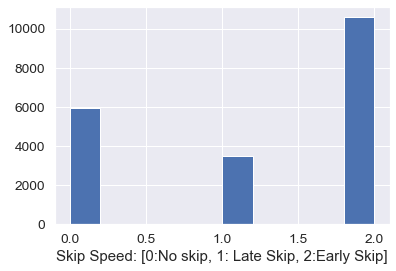

In [114]:
### checking the type of column
for col in df.columns:
    print(col,df[col].dtype)
## Hence, need to convert the skip speed intp categorical variables  
plt.hist(df['skip_speed'])
plt.xlabel('Skip Speed: [0:No skip, 1: Late Skip, 2:Early Skip]')

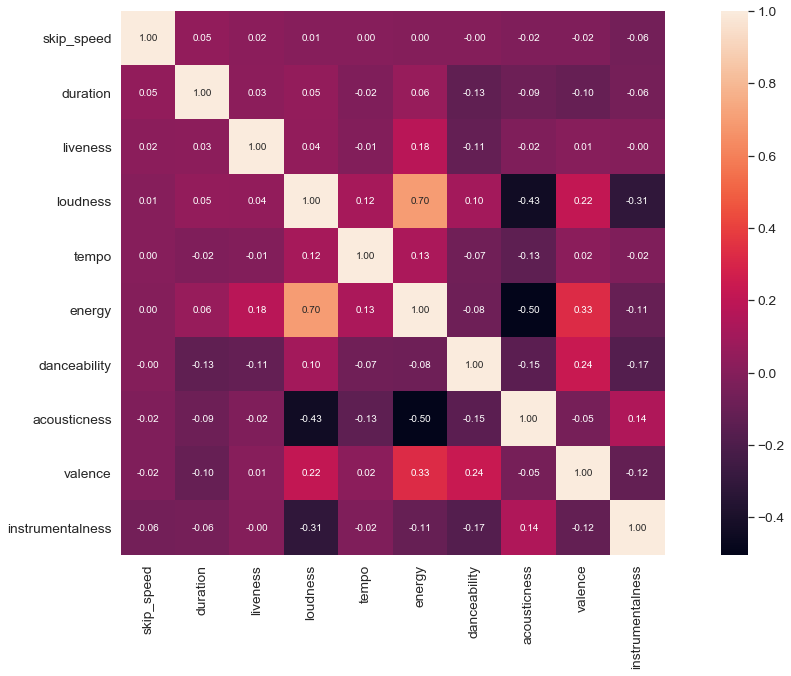

In [100]:
corrmat = df.corr()
plt.figure(figsize=(20,10))
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'skip_speed')['skip_speed'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [220]:
######creating train and validation datasets#####
x_train_partial,x_val,y_train_partial,y_val=train_test_split(x_train,y_train,test_size=0.25,random_state=40,shuffle=True)

### Multinomial logistic Regression

/Users/ishagupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


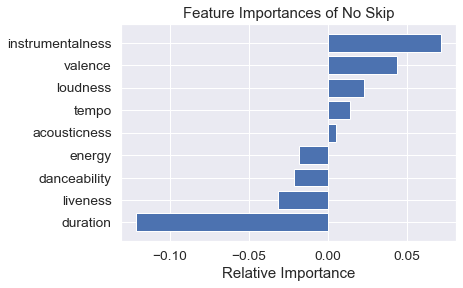

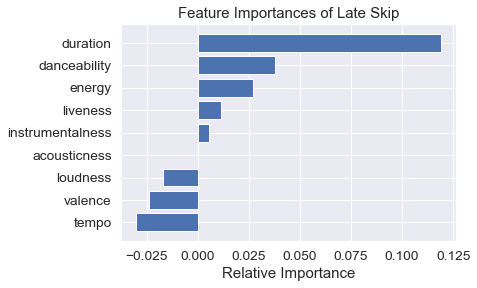

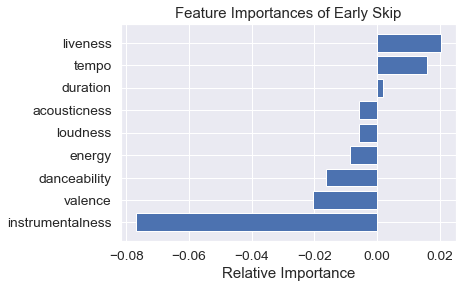

In [262]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(multi_class='multinomial',solver='lbfgs').fit(x_train_partial,y_train_partial)
logreg.predict_proba(x_val)
log_loss(y_val,logreg.predict_proba(x_val))
logreg.coef_[0]

#print('Importances for class 0: No skip at all\n')
# for name, importance in zip(df.columns[:-1],logreg.coef_[0]):
#     print(name,'=',importance)
   
classes=['No Skip','Late Skip','Early Skip']
#fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
#fig=plt.figure((1,3,i))
for j in range(1,4):
    features=df.columns[:-1]
    importance=logreg.coef_[j-1]
    indices=np.argsort(importance)
    ax = fig.add_subplot(1, 3, j)
    plt.title(f'Feature Importances of {classes[j-1]}')
    #ax.subplot(1,3,j)
    plt.barh(range(len(indices)),importance[indices],align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

### K Nearest Neighbours

Text(0.5, 0, 'Number of Neighbours')

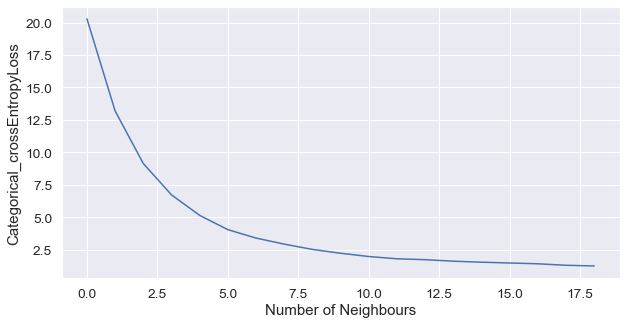

In [176]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss

method='K nearest Neighbours'
neighbour_grid=np.arange(1,20)
result_dict=dict()
for num_neigh in neighbour_grid:
    model1=KNeighborsClassifier(n_neighbors=num_neigh)
    model1.fit(x_train_partial,np.array(y_train_partial))
    predicted=model1.predict_proba(x_val)
    loss=log_loss(np.array(y_val),predicted)
    result_dict[num_neigh]=loss

fig=plt.figure(figsize=(10,5))
plt.plot(list(result_dict.values()))
plt.ylabel('Categorical_crossEntropyLoss')
plt.xlabel('Number of Neighbours')


In [171]:
#### From the plot above, choosing 4 as the best nearest neighbours
num_neigh=4
method='K nearest Neighbours'
### Training on entire train and then Checking on test
model1=KNeighborsClassifier(n_neighbors=num_neigh)
model1.fit(x_train,np.array(y_train))
predicted=model1.predict_proba(x_test)
loss=log_loss(np.array(y_test),predicted)
print(f'Choosing {num_neigh} as the number of nearest neighbours, Log loss for Knearest neighbours method is {loss}.')
Final_Results_dict[method]=dict()
Final_Results_dict[method]['Log_Loss']=loss
Final_Results_dict[method]['Accuracy']=model1.score(x_test,y_test)

Choosing 4 as the number of nearest neighbours, Log loss for Knearest neighbours method is 6.528984707106509.


In [408]:
Final_Results_dict[method]['Accuracy']

0.4176

### SVM

Note: In case of support vector classifier, the fit time scales quadratically with the number of samples

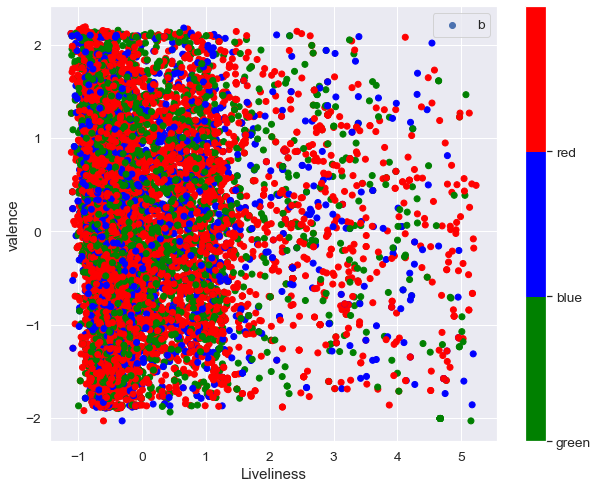

In [218]:
import matplotlib
colors = ['green','blue','red']
label=np.array([y_train])
fig = plt.figure(figsize=(10,8))
# for i in range(28)
# fig=plt.subplot(4,7,i+1)
plt.scatter(np.array([x_train[:,5]]), np.array([x_train[:,8]]), c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(list(label[0])),max(list(label[0]))/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)
plt.xlabel('Liveliness')
plt.ylabel('valence')
plt.legend('best')

#Red is early skip, blue is late skip and green is no skip

#### We will use One Vs Rest as the data is imbalanced and also it is computationally less expensive as compared to One vs one

In [295]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#scaled_svc=make_pipeline(StandardScaler(),SVC())
param_grid={'svc__C':np.logspace(-3,2,6),
            'svc__gamma': np.logspace(-3,2,6)/x_train_partial.shape[0]}

#grid=GridSearchCV(scaled_svc,param_grid=param_grid,cv=10)
#results=grid.fit(x_train,y_train)
svc_results_grid=dict()
gamma_grid=np.logspace(-3,2,6)/x_train_partial.shape[0]
c_grid=np.logspace(-3,2,6)
for gamma in gamma_grid:
    for c in c_grid:
        svc=SVC(gamma=gamma,C=c)
        svc.fit(x_train_partial,y_train_partial)
        score=svc.score(x_val,y_val)
        svc_results_grid[(gamma,c)]=score

In [297]:
#svc_results_grid

### Neural Network

In [336]:
from keras import models
from keras import layers
from keras import metrics
from keras import optimizers

dataset=x_train
def build_model(dropout=0.3,nodes=32):
    model=models.Sequential()
    model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(3,activation='softmax'))

    adam = optimizers.Adam(lr=0.01, decay=1e-6)
    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[metrics.categorical_accuracy])
    return model

In [374]:
model=build_model(dropout=0.6)
model.summary()

y_train_nn=pd.get_dummies(pd.DataFrame(y_train_partial))
y_val_nn=pd.get_dummies(pd.DataFrame(y_val))


history=model.fit(x_train_partial,y_train_nn,validation_data=(x_val,y_val_nn),epochs=200,verbose=0,batch_size=100)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 64)                640       
_________________________________________________________________
dropout_43 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_44 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_45 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)             

##### Simplest neural network with 1 hidden layer of 32 neurons - to be used as baseline for hyperparameter tuning

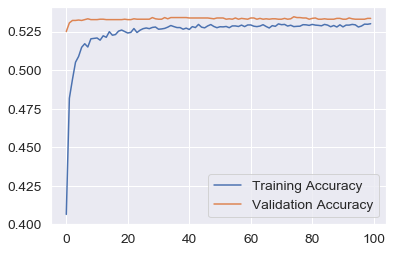

In [311]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
#plt.plot(history.history['val_mae'],label='MAE')
#plt.plot(history.history['mape'])
#plt.plot(history.history['cosine'],label='Cosine')
plt.legend(loc='best')
plt.show()


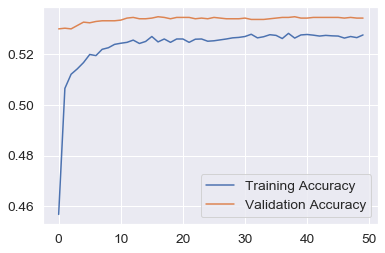

In [322]:
plt.plot(history.history['categorical_accuracy'],label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'],label='Validation Accuracy')
#plt.plot(history.history['val_mae'],label='MAE')
#plt.plot(history.history['mape'])
#plt.plot(history.history['cosine'],label='Cosine')
plt.legend(loc='best')
plt.show()

#### Adam optimizers

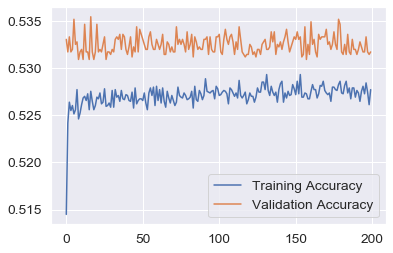

0.5277333
0.5317333340644836


In [338]:
plt.plot(history.history['categorical_accuracy'],label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'],label='Validation Accuracy')
#plt.plot(history.history['val_mae'],label='MAE')
#plt.plot(history.history['mape'])
#plt.plot(history.history['cosine'],label='Cosine')
plt.legend(loc='best')
plt.show()

print(history.history['categorical_accuracy'][-1])
print(history.history['val_categorical_accuracy'][-1])

In [357]:
y_test_nn=pd.get_dummies(pd.DataFrame(y_test.astype('category')))
model.evaluate(x_test,y_test_nn)

5000/5000 [==============================] - 0s 29us/step


[0.9955488874435425, 0.5382000207901001]

In [406]:
def build_model(dropout=0.3,nodes=64):
    model=models.Sequential()
    model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    #model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    #model.add(layers.Dropout(dropout))
    #model.add(layers.Dense(int(nodes/2),activation='relu',input_shape=(dataset.shape[1],)))
    #model.add(layers.Dropout(dropout))
    model.add(layers.Dense(3,activation='softmax'))

    adam = optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['acc'])
    return model


model=build_model()
model.summary()

y_train_nn=pd.get_dummies(pd.DataFrame(y_train_partial))
y_val_nn=pd.get_dummies(pd.DataFrame(y_val))


history=model.fit(x_train_partial,y_train_nn,validation_data=(x_val,y_val_nn),epochs=200,verbose=0,batch_size=100)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 64)                640       
_________________________________________________________________
dropout_48 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_49 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 128)             

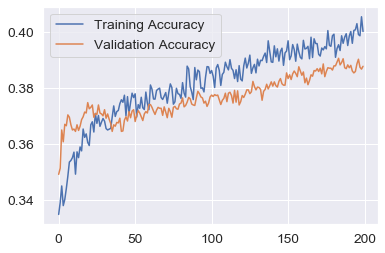

0.40032652
0.3878757059574127


In [407]:
plt.plot(history.history['acc'],label='Training Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
#plt.plot(history.history['val_mae'],label='MAE')
#plt.plot(history.history['mape'])
#plt.plot(history.history['cosine'],label='Cosine')
plt.legend(loc='best')
plt.show()

print(history.history['acc'][-1])
print(history.history['val_acc'][-1])

#### As the accuracy is lying only around 50%, let's try to balance the dataset

##### Over sampling

In [373]:
!pip install imblearn
from imblearn.over_sampling import SMOTE

     |████████████████████████████████| 163 kB 1.3 MB/s eta 0:00:01


In [377]:
smote=SMOTE('minority')
x_sm,y_sm=smote.fit_sample(x_train,y_train)
x_sm.shape,y_sm.shape

((20246, 9), (20246,))

/Users/ishagupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


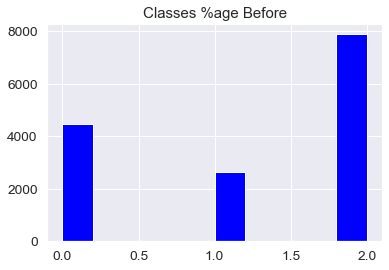

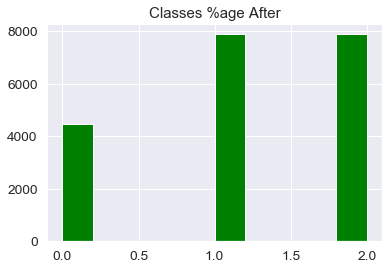

In [392]:
ys=[y_train,y_sm]
color=['blue','green']
when=['Before','After']
for j in range(1,3):
    ax=fig.add_subplot(1,2,j)
    plt.hist(ys[j-1],color=color[j-1])
    plt.title(f'Classes %age {when[j-1]}')
    plt.show()


In [398]:
x_train_partial,x_val,y_train_partial,y_val=train_test_split(x_sm,y_sm,test_size=0.25)

y_train_nn=pd.get_dummies(pd.DataFrame(y_train_partial))
y_val_nn=pd.get_dummies(pd.DataFrame(y_val))


history=model.fit(x_train_partial,y_train_nn,validation_data=(x_val,y_val_nn),epochs=200,verbose=0,batch_size=100)

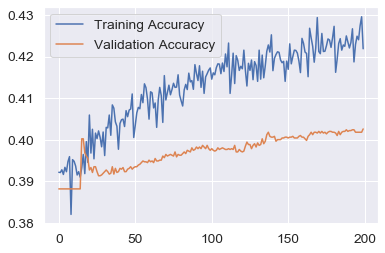

0.42189145
0.40260767936706543


In [399]:
plt.plot(history.history['acc'],label='Training Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
#plt.plot(history.history['val_mae'],label='MAE')
#plt.plot(history.history['mape'])
#plt.plot(history.history['cosine'],label='Cosine')
plt.legend(loc='best')
plt.show()

print(history.history['acc'][-1])
print(history.history['val_acc'][-1])

In [400]:
y_test_nn=pd.get_dummies(pd.DataFrame(y_test.astype('category')))
model.evaluate(x_test,y_test_nn)

5000/5000 [==============================] - 0s 37us/step


[1.143806499862671, 0.19059999287128448]

In [402]:
smote=SMOTE('minority')
x_sm_new,y_sm_new=smote.fit_sample(x_sm,y_sm)

/Users/ishagupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


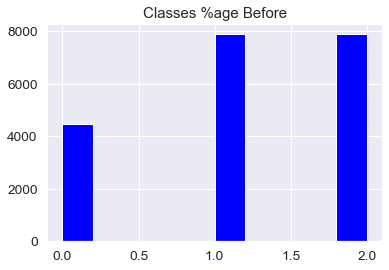

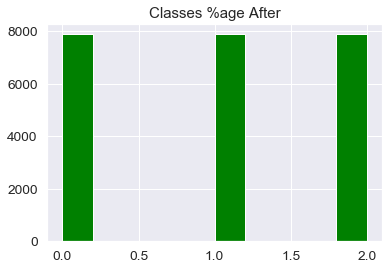

In [403]:
ys=[y_sm,y_sm_new]
color=['blue','green']
when=['Before','After']
for j in range(1,3):
    ax=fig.add_subplot(1,2,j)
    plt.hist(ys[j-1],color=color[j-1])
    plt.title(f'Classes %age {when[j-1]}')
    plt.show()


In [404]:
x_train_partial,x_val,y_train_partial,y_val=train_test_split(x_sm_new,y_sm_new,test_size=0.25,shuffle=True)

y_train_nn=pd.get_dummies(pd.DataFrame(y_train_partial))
y_val_nn=pd.get_dummies(pd.DataFrame(y_val))


history=model.fit(x_train_partial,y_train_nn,validation_data=(x_val,y_val_nn),epochs=200,verbose=0,batch_size=100)

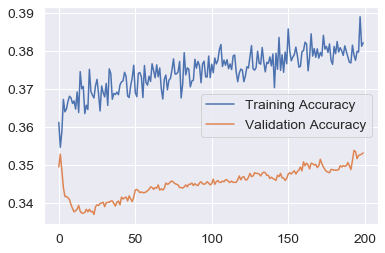

0.38225526
0.35325902700424194


In [405]:
plt.plot(history.history['acc'],label='Training Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
#plt.plot(history.history['val_mae'],label='MAE')
#plt.plot(history.history['mape'])
#plt.plot(history.history['cosine'],label='Cosine')
plt.legend(loc='best')
plt.show()

print(history.history['acc'][-1])
print(history.history['val_acc'][-1])